In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import joblib

# %matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from os.path import join
from jupyter_utils.progress_bar import ProgressBar
from functools import partial

from nabirds import CUB_Annotations, NAB_Annotations, Dataset

from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import minimize, minimize_scalar, Bounds

from skimage.transform import resize
from skimage.feature import peak_local_max

from chainer.cuda import to_cpu
from chainer.iterators import SerialIterator, MultiprocessIterator
from chainer.dataset.convert import concat_examples
from chainer_addons.models import InceptionV3, VGG19Layers, ResnetLayers

import chainer
import chainer.functions as F

chainer.__version__

'4.2.0'

In [3]:
BASE_DIR = "/home/korsch/Data"

infos = dict(
    
    # VGG19 Features
    
    NAC_single=dict(
        data="NAC/2017-bilinear",
        feat_suffix="10parts_new"
    ),
    
    NAC_vgg=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts"
    ),
    
    
    # ResNet50 Features
    
    NAC_resnet=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.resnet"
    ),
    
    GT_resnet=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.resnet"
    ),
    
    # InceptionV3 Features
    
    NAC_inception=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.inception"
    ),
    
    GT_inception=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.inception"
    ),
    
    GT2_inception=dict(
        data="cub200_11_regrouped",
        feat_suffix="5parts_gt.inception"
    )
)
DATASET="NAC_inception"
info = infos[DATASET]
DATA_DIR = join(BASE_DIR, "DATASETS", "birds", info["data"])

DUMP = True

GPU = 0
BATCH_SIZE = 12

In [4]:
def prepare_batch(batch, func):
    return [(func(b[0]),) + b[1:] for b in batch]

In [5]:
print("Loading annotations from \"{}\"...".format(DATA_DIR))
annot = CUB_Annotations(DATA_DIR)

print("Creating train and test datasets")
splits = [annot.train_uuids, annot.test_uuids]
features = [join(DATA_DIR, "features", "{}_{}.npz".format(s, info["feat_suffix"])) 
            for s in ["train", "val"]]

train, val = [Dataset(uuids=s, annotations=annot, features=feats) 
               for s, feats in zip(splits, features)]

data = val

Loading annotations from "/home/korsch/Data/DATASETS/birds/NAC/2017-bilinear"...
Creating train and test datasets


# Fit Scaler only on training data!

In [6]:
scaler = MinMaxScaler()
scaler.fit(train.features[:, -1])

MinMaxScaler(copy=True, feature_range=(0, 1))

# Load SVM Classifier

Validation Accuracy: 87.3317%
Validation Accuracy (Top5): 95.5299%


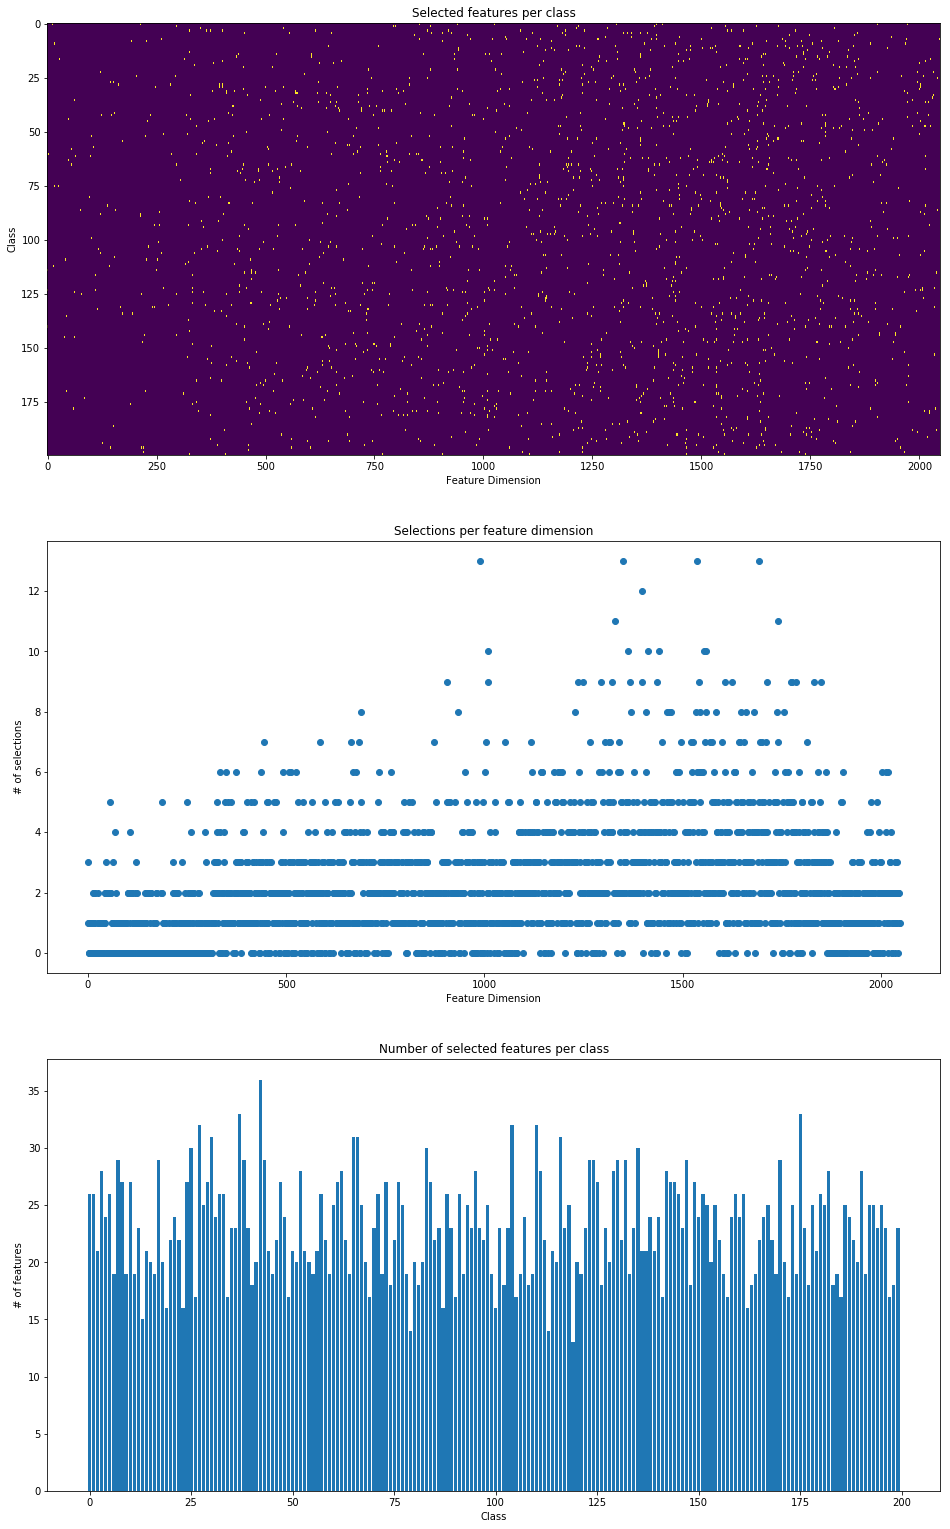

In [7]:
X = scaler.transform(data.features[:, -1])
y = data.labels
clf = joblib.load("clf_{}_glob_only_sparse_coefs.npz".format(DATASET))

COEFS = clf.coef_

print("Validation Accuracy: {:.4%}".format(clf.score(X, y)))

decs = clf.decision_function(X)
top5_preds = np.argsort(decs)[:, -5:]
top5_accu = (top5_preds == np.expand_dims(y, 1)).max(axis=1).mean()
print("Validation Accuracy (Top5): {:.4%}".format(top5_accu))


fig, ax = plt.subplots(3, 1, figsize=(16, 9*3))
ax[0].set_title("Selected features per class")
ax[0].set_xlabel("Feature Dimension")
ax[0].set_ylabel("Class")
ax[0].imshow(clf.coef_ != 0, aspect="auto")

ax[1].set_title("Selections per feature dimension")
ax[1].set_xlabel("Feature Dimension")
ax[1].set_ylabel("# of selections")
# ax[1].imshow((clf.coef_ != 0).sum(axis=0, keepdims=True), aspect="auto")
ax[1].scatter(range(clf.coef_.shape[1]), (clf.coef_ != 0).sum(axis=0))

ax[2].set_title("Number of selected features per class")
ax[2].set_xlabel("Class")
ax[2].set_ylabel("# of features")
ax[2].bar(range(len(clf.coef_)), (clf.coef_ != 0).sum(axis=1))
plt.show()
plt.close()

print()

# Create CNN Model

In [8]:
BASE_MODEL_DIR = join(BASE_DIR, "MODELS")

if "inception" in DATASET:
    cnn = InceptionV3(aux_logits=False)
    weights=join(BASE_MODEL_DIR, "inception", "ft_cub200", "sgd.inat_pretrain/g_avg_pooling/model.npz")
    
elif "resnet" in DATASET:
    cnn = ResnetLayers()
    weights=join(BASE_MODEL_DIR, "resnet", "ft_cub200", "model.npz")
    
else:
    cnn = VGG19Layers()
    weights=join(BASE_MODEL_DIR, "vgg19", "ft_cub200", "model.npz")
    
    
cnn.load_for_inference(
        n_classes=201,
        weights=weights)

In [9]:
if GPU >= 0:
    chainer.cuda.get_device(GPU).use()
    cnn.to_gpu(GPU)

# Create Dataset Iterator

In [10]:
it = SerialIterator(data, batch_size=BATCH_SIZE, repeat=False, shuffle=False)

In [11]:
def show_conv_maps(ims, labs, conv_maps, topk_preds, alpha=0.7, order=1):
    
    preds = topk_preds[:, -1]
    
    gt_coefs = COEFS[to_cpu(labs)]
    
    topk_pred_coefs = [COEFS[to_cpu(p)] for p in topk_preds.T]
    pred_coefs = topk_pred_coefs[-1]

    for i in range(len(ims)):
        im, conv, gt_c, pred_c = ims[i], conv_maps[i], gt_coefs[i], pred_coefs[i]
        pred_y, gt_y = preds[i], labs[i]
        
        _resize = partial(resize, 
                          order=order,
                          output_shape=im.shape[1:], 
                          mode="edge",
                          anti_aliasing=True,
                         )
        
        def show_conv(conv, ax, title, coef=None, best_n=10):
            if coef is None:
                _conv = np.abs(conv).sum(axis=0)
            else:
                best_coef = np.argsort(np.abs(coef))[-best_n:]
                _conv = conv * coef.reshape(-1, 1, 1)
                _conv = np.abs(_conv[best_coef]).sum(axis=0)
                
            _conv = _resize(normalize(_conv, axis=None))
            ax.imshow(_conv, alpha=alpha)
            ax.set_title(title)
        
        fig, ax = plt.subplots(1,3, figsize=(16, 9))
        for a in ax:
            a.imshow(prepare_back(im))
        
        show_conv(conv, ax=ax[0], 
                  title="Full Conv Map")
        show_conv(conv, ax=ax[1], 
                  title="Pred Conv Map (class {})".format(pred_y), 
                  coef=pred_c)
        show_conv(conv, ax=ax[2], 
                  title="GT Conv Map (class {})".format(gt_y), 
                  coef=gt_c)
        
        continue
        c0 = (conv * gt_c.reshape(-1,1,1))[gt_c != 0]
        c1 = (conv * pred_c.reshape(-1,1,1))[pred_c != 0]
        for gt_conv, pred_conv in zip(c0, c1):
            fig, axs = plt.subplots(figsize=(16, 9))
            
            # gt_conv = _resize(normalize(gt_conv, axis=None))
            # axs[0].imshow(prepare_back(im))
            # axs[0].imshow(gt_conv, alpha=alpha)#, interpolation="bilinear")
            
            pred_conv = _resize(normalize(pred_conv, axis=None))
            axs.imshow(prepare_back(im))
            axs.imshow(pred_conv, alpha=alpha)#, interpolation="bilinear")
            
            plt.show()
            plt.close()
            
        break

In [12]:
def prepare_back(im):
    im = im.array if hasattr(im, "array") else im
    return normalize(to_cpu(im)).transpose(1, 2, 0)

def normalize(im, axis=(1,2)):
    im = im - im.min(axis=axis, keepdims=True)
    chan_max = im.max(axis=axis, keepdims=True)
    if 0 in chan_max:
        return im
    else:
        return im / chan_max

def imshow(im, ax=None, figsize=(32,18), **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    ax.axis("off")
    return ax
    
def prop_back(from_, to, coefs=None):
    global cnn
    to.grad = None
    cnn.cleargrads()

    if coefs is None:
        F.sum(from_).backward()
    else:
        F.sum(from_[np.where(coefs)]).backward()
    
    assert to.grad is not None, "Backprop mode is off?"
    return to.grad

# def grad_from_coefs(feats, coefs, normalize=False):
#     grad = np.zeros_like(to_cpu(feats.array))
#     sel_coefs = np.where(coefs)
#     grad[sel_coefs] = 1
#     if not normalize:
#         return grad
    
#     sample_idxs = sel_coefs[0]
#     sel_per_sample = np.bincount(sample_idxs).reshape(-1, 1)
#     grad /= sel_per_sample
#     return grad

def grad_to_im(grad, xp=np, keepdims=True):
    return xp.abs(grad).mean(axis=0, keepdims=keepdims)

In [13]:
def _norm(arr):
    arr = arr - arr.min()
    return arr / arr.max()

def _as_cluster_feats(im, grad, coords):
    ys, xs = coords
    _im = im[ys, xs]
    return np.stack([
        _norm(ys),
        _norm(xs),
        _norm(grad[ys, xs].ravel()),
        _norm(_im[:, 0].ravel()), 
        _norm(_im[:, 1].ravel()), 
        _norm(_im[:, 2].ravel()),
    ]).transpose()

def cluster_gradient(im, grad, K=4, thresh=None, init_from_maximas=False):
    ### get x,y coordinates
    if thresh is None:
        idxs = np.arange(np.multiply(*grad.shape))
        coords = np.unravel_index(idxs, grad.shape)
    else:
        coords = np.where(np.abs(grad) >= thresh)
        
    data = _as_cluster_feats(im, grad, coords)
    
    if init_from_maximas:
        init_coords = peak_local_max(grad, num_peaks=K).T
        init = _as_cluster_feats(im, grad, init_coords)
        clf = KMeans(K, init=init, n_init=1)
    else:
        clf = KMeans(K)
        
    clf.fit(data)
    labels = np.full(grad.shape, np.nan)
    labels[coords] = clf.labels_
    centers = clf.cluster_centers_.copy()
    centers[:, 0] *= grad.shape[0]
    centers[:, 1] *= grad.shape[1]
    
    return centers, labels 

def fit_bbox(mask, grad=None, optimize=False):
    ys, xs = np.where(mask)
    bbox = np.array([min(ys), min(xs), max(ys), max(xs)])
    
    if not optimize: 
        return bbox
    
    y0, x0, y1, x1 = bbox
    h, w = y1 - y0, x1 - x0
    search_area = mask[y0:y1, x0:x1].astype(np.float32)
    if grad is not None:
        assert 0.0 <= grad.max() <= 1.0
        search_area *= grad[y0:y1, x0:x1]
    scaler = np.array([h, w, h, w])
    
    # (1) Our search area is [(x0,y0), (x1,y1)]. 
    # (2) If we  shift it with (x0,y0) it becomes [(0,0), (w,h)]
    # (3) We see it in normalized way, so it changes to [(0,0), (1,1)]
    # (4) The initial bbox is then always [(0.25, 0.25), (0.75, 0.75)]  with width and height 0.5
    
    init_bbox = np.array([0.25, 0.25, 0.75, 0.75])
    
    def _measures(b, mask):
        # scale back to the area mentioned in (2)
        y0, x0, y1, x1 = map(int, b * scaler)
        area = mask[y0:y1, x0:x1]
        TP = area.sum()
        FP = (1-area).sum()
        FN = mask.sum() - TP
        TN = (1-mask).sum() - FP
        return TP, FP, FN, TN
    
    def Recall(b, mask):
        TP, FP, FN, TN = _measures(b, mask)
        return -(TP / (TP + FN))
    
    def Precision(b, mask):
        TP, FP, FN, TN = _measures(b, mask)
        return -(TP / (TP + TN))
    
    def Fscore(b, mask, beta=1):
        TP, FP, FN, TN = _measures(b, mask)
        recall = TP / (TP + FN)
        prec = TP / (TP + TN)
        
        return -((1 + beta**2) * (recall * prec) / (recall + beta**2 * prec) )
    
    F2 = partial(Fscore, beta=2)
    F1 = partial(Fscore, beta=1)
    F0_5 = partial(Fscore, beta=0.5)
    
    res = minimize(Recall, init_bbox, 
                   args=(search_area,),
                   options=dict(eps=1e-2, gtol=1e-1),
                   bounds=Bounds(0, 1),
                  )
    # scale back to (2) and shift to original values (1)
    return res.x * scaler + np.array([y0, x0, y0, x0])
    
def get_boxes(centers, labels, **kwargs):
    values = labels[np.logical_not(np.isnan(labels))]
    res = []
    for i in np.unique(values):
        y0, x0, y1, x1 = fit_bbox(labels == i, **kwargs)
        h, w = y1 - y0, x1 - x0
        res.append([i, ((x0, y0), w, h)])
    return res

def plot_gradient(im, grad, ax=None, title="", 
                  alpha=0.5, gamma=1.0, sigma=1,  
                  peak_size=None, K=None, init_from_maximas=False):
    if sigma is None:
        grad = grad.squeeze()
    else:
        grad = gaussian_filter(grad, sigma=sigma).squeeze()
    
    grad = grad**gamma
    
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 9))
    
    #ax = imshow(im, ax=ax)
    ax = imshow(np.zeros_like(im), ax=ax)
       
    ax = imshow(grad, ax=ax, 
                cmap=plt.cm.viridis, alpha=alpha)
    
    cmap = plt.cm.jet
    if K is not None:
        thresh = np.abs(grad).mean()
        centers, labs = cluster_gradient(im, grad, K=K, thresh=thresh, init_from_maximas=init_from_maximas)
        ys, xs = centers[:, :2].T
        ax.scatter(xs, ys, marker="D", c=range(K), cmap=cmap)
        ax.imshow(labs, cmap=cmap, alpha=0.3)
        
        boxes = get_boxes(centers, labs, 
                          optimize=False,
                         )
        for c, box in boxes:
            ax.add_patch(Rectangle(
                *box, fill=False,
                color=cmap(c / len(boxes)),  
                linestyle="--", alpha=0.5 
            ))
            
        boxes = get_boxes(centers, labs, 
                          optimize=True,
                          grad=grad
                         )
        for c, box in boxes:
            ax.add_patch(Rectangle(
                *box, fill=False,
                color=cmap(c / len(boxes))))
        
    if peak_size is not None:
        peaks = peak_local_max(
                grad, 
                min_distance=peak_size, 
                exclude_border=False)
        
        ys, xs = peaks.T
        ax.scatter(xs, ys, marker="x", c="blue")
        
    
    ax.set_title(title)
    
    return ax

In [14]:
def show_feature_saliency(ims, labs, feats, topk_preds,
                          **kwargs):
    global COEFS, cnn
    xp = cnn.xp
    
    normalize_grads = False
    preds = topk_preds[:, -1]

    gt_coefs = COEFS[to_cpu(labs)]
    gt_im_grad = prop_back(feats, ims, gt_coefs != 0)

    topk_pred_coefs = [COEFS[to_cpu(p)] for p in topk_preds.T]
    topk_pred_im_grad = [prop_back(feats, ims, p != 0) for p in topk_pred_coefs]
    
    pred_coefs = topk_pred_coefs[-1]
    pred_im_grad = topk_pred_im_grad[-1]
    
    full_im_grad = prop_back(feats, ims)
    
    
    for g in [full_im_grad, pred_im_grad]:
        print(g.min(), g.max())
        
    _plot_gradient = partial(plot_gradient, **kwargs)
    
    for i, (gt_coef, pred_coef) in enumerate(zip(gt_coefs, pred_coefs)):
        
        print("GT class: {}, pred class: {}".format(labs[i], preds[i]))
        fig, axs = plt.subplots(2, 2, figsize=(16, 9))

        im = prepare_back(ims[i])
        ax = imshow(im, ax=axs[0,0])
        ax.set_title("Original Image predicted: {}, true: {}".format(preds[i], labs[i]))
        
        #diff_grad = normalize(full_im_grad[i]) - normalize(pred_im_grad[i])
        #g = prepare_back(grad_to_im(diff_grad, cnn.xp))
        g = prepare_back(grad_to_im(gt_im_grad[i], cnn.xp))
        _plot_gradient(im, g, 
                       ax=axs[np.unravel_index(1, axs.shape)],
                       title="GT Gradient",
                      )
        
        g = prepare_back(grad_to_im(pred_im_grad[i], cnn.xp))
        _plot_gradient(im, g, 
                       ax=axs[np.unravel_index(2, axs.shape)],
                       title="Pred Gradient",
                      )
        
        g = prepare_back(grad_to_im(full_im_grad[i], cnn.xp))
        _plot_gradient(im, g,
                       ax=axs[np.unravel_index(3, axs.shape)],
                       title="Full Gradient",
                      )
        
        plt.show()
        plt.close()
        
        ############### Plots Top-k Gradients ###############
        if False:#i == 0:
            grads_coefs_preds = list(zip(
                topk_pred_im_grad, 
                topk_pred_coefs, 
                topk_preds[i]
            ))
            
            _coefs = np.array([c[i] for c in topk_pred_coefs])
            fig, ax = plt.subplots(figsize=(16, 9))
            # reverse first axis, so that top prediction is displayed first
            ax.imshow(_coefs[::-1] != 0, aspect="auto")
            for k, (_grad, _coef, _pred) in enumerate(reversed(grads_coefs_preds), 1):
                g = prepare_back(grad_to_im(_grad[i], cnn.xp))
                _plot_gradient(im, g, ax=None,
                               title="Pred #{} Gradient (Class {})".format(k, _pred),
                              )
            plt.show()
            plt.close()
        #####################################################
        
        
        
        ############### Plots Gradients of the selected Features ###############
        if False:#i == 0:
            for feat_idx in np.where(pred_coef)[0]:
                mask = np.zeros_like(pred_coefs).astype(bool)
                mask[i, feat_idx] = True
                _grad = prop_back(feats, ims, mask)
                
                g = prepare_back(grad_to_im(_grad[i], cnn.xp))
                _plot_gradient(np.zeros_like(im), g,
                               ax=None,#axs[0],
                               title="Feat Gradient #{}".format(feat_idx),
                               **kwargs
                              )
                
                plt.show()
                plt.close()
        ########################################################################
        
        # break

In [15]:
def get_parts(im, grad,
              alpha=0.5, gamma=1.0, sigma=1,  
              peak_size=None, K=None, init_from_maximas=False):

        if sigma is None:
            grad = grad.squeeze()
        else:
            grad = gaussian_filter(grad, sigma=sigma).squeeze()

        grad = grad**gamma
        
        assert K is not None, "For extraction K is required!"
        
        thresh = np.abs(grad).mean()
        centers, labs = cluster_gradient(
            im, grad, 
            K=K, thresh=thresh, 
            init_from_maximas=init_from_maximas
        )

        #### Naive Boxes 
        #_boxes = get_boxes(centers, labs, 
        #                  optimize=False,
        #                 )

        #### Boxes optimized for maximum recall
        return get_boxes(centers, labs, 
                          optimize=True, 
                          grad=grad
                         )
        
        ### Not Used for Part extraction!
        # if peak_size is not None:
        #    peaks = peak_local_max(
        #             grad, 
        #             min_distance=peak_size, 
        #            exclude_border=False)
        #    ys, xs = peaks.T
        
def extract_parts(ims, labs, feats, topk_preds,
                  **kwargs):
    global COEFS, cnn
    xp = cnn.xp
    
    normalize_grads = False
    preds = topk_preds[:, -1]

    gt_coefs = COEFS[to_cpu(labs)]
    gt_im_grad = prop_back(feats, ims, gt_coefs != 0)

    topk_pred_coefs = [COEFS[to_cpu(p)] for p in topk_preds.T]
    topk_pred_im_grad = [prop_back(feats, ims, p != 0) for p in topk_pred_coefs]
    
    pred_coefs = topk_pred_coefs[-1]
    pred_im_grad = topk_pred_im_grad[-1]
    
    full_im_grad = prop_back(feats, ims)
    _get_parts = partial(get_parts, **kwargs)
    
    for i, (gt_coef, pred_coef) in enumerate(zip(gt_coefs, pred_coefs)):
        im = prepare_back(ims[i])
        
        #g = prepare_back(grad_to_im(pred_im_grad[i], cnn.xp))
        #gt_parts = _get_parts(im, g)
        
        g = prepare_back(grad_to_im(pred_im_grad[i], cnn.xp))
        pred_parts = _get_parts(im, g)

        g = prepare_back(grad_to_im(full_im_grad[i], cnn.xp))
        full_parts = _get_parts(im, g)
        yield pred_parts, full_parts

def parts_to_file(im_id, part_id, box, out):
    (x, y), w, h = box
    # TODO: remove the x-axis flipping
    if "inception" in DATASET:
        x = 299 - (x + w) # flip x-axis
        
    print(im_id+1, int(part_id+1), *map(int, map(round, [x,y,w,h])),
         file=out
    )

Batch Accuracy: 91.6667% (Top1) | 100.0000% (Top5)  11 /  12
-51.43325 50.64605
-4.125809 4.5456314
GT class: 0, pred class: 0


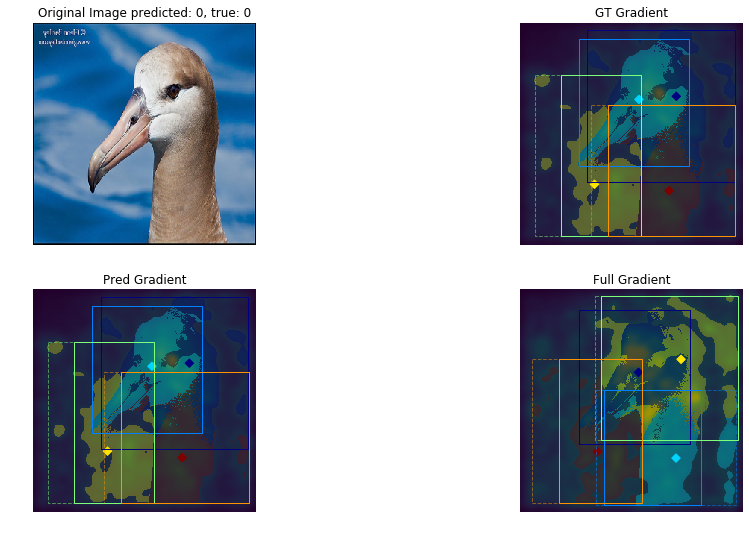

GT class: 0, pred class: 0


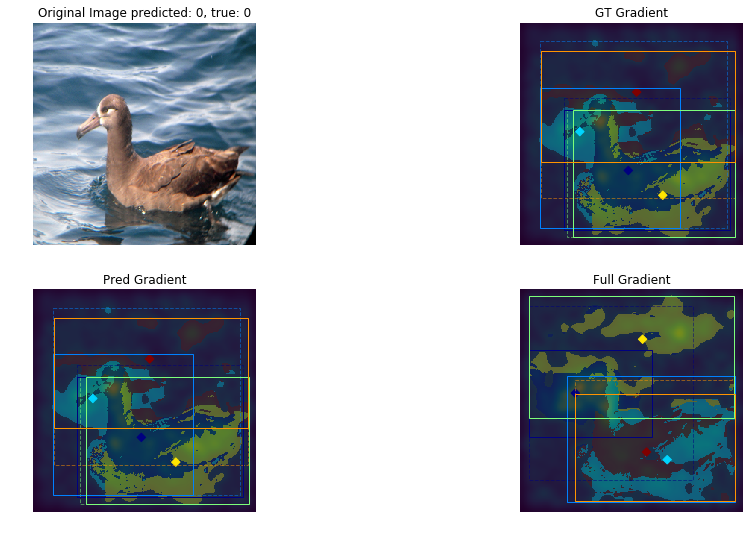

GT class: 0, pred class: 0


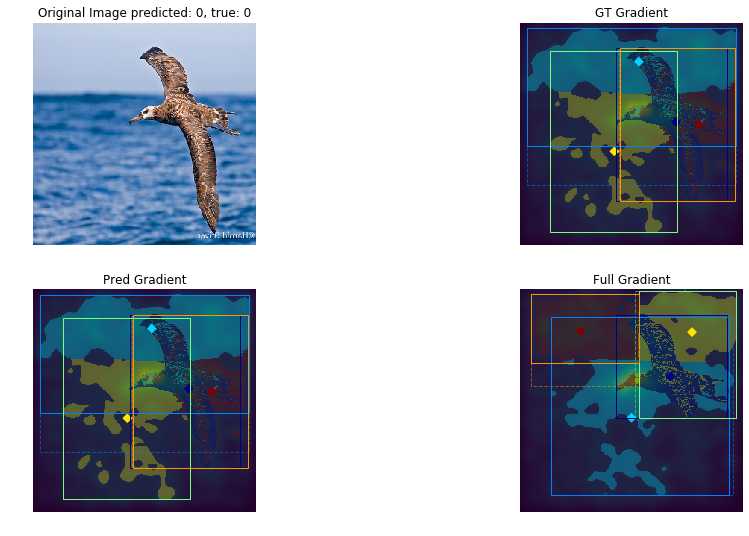

GT class: 0, pred class: 0


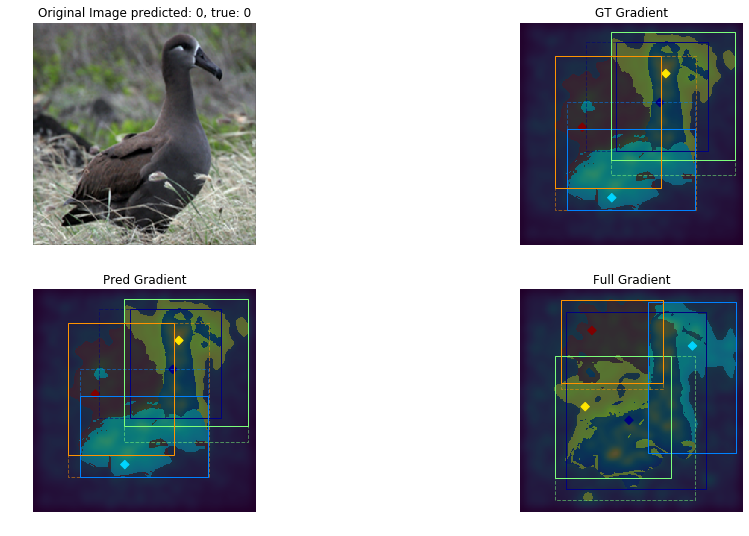

GT class: 0, pred class: 0


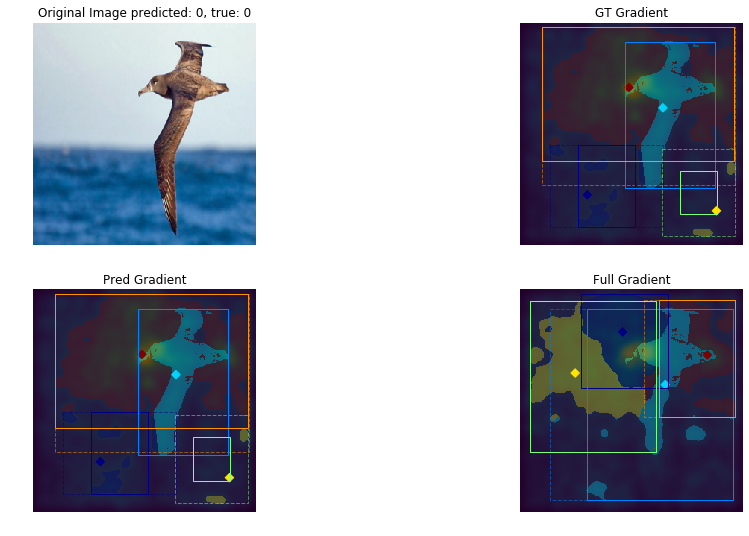

GT class: 0, pred class: 1


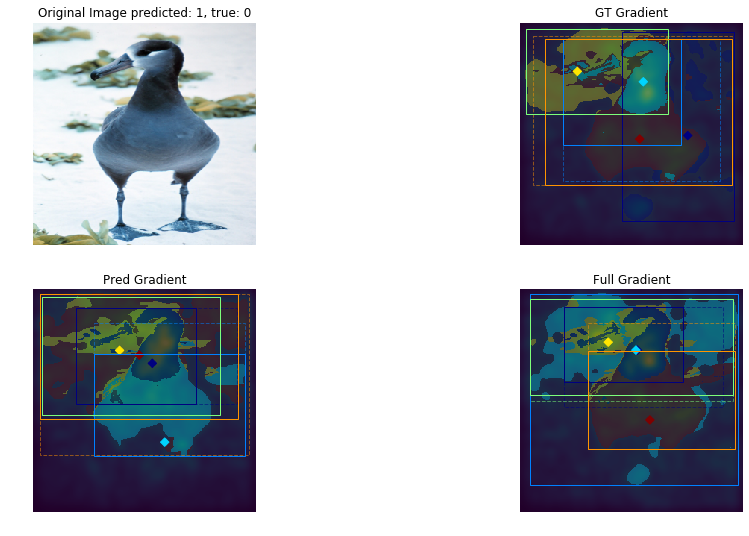

GT class: 0, pred class: 0


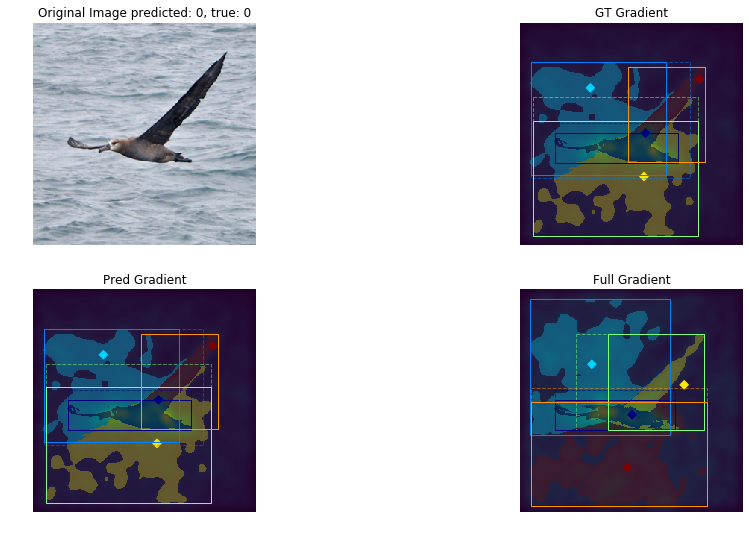

GT class: 0, pred class: 0


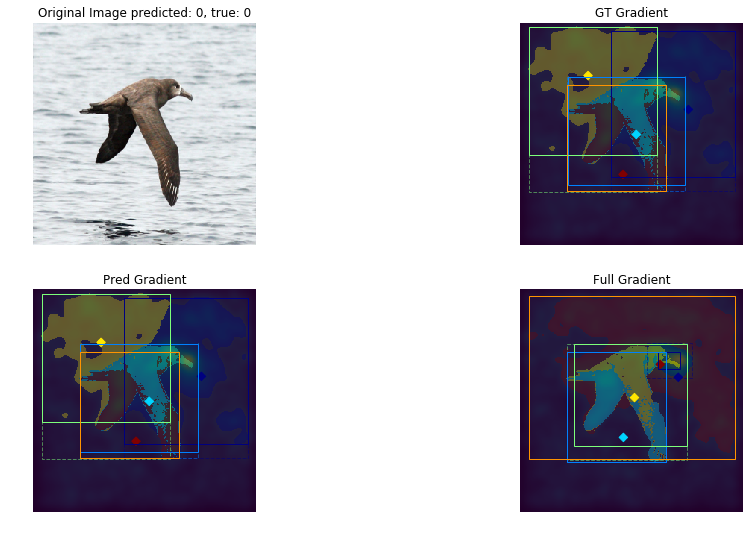

GT class: 0, pred class: 0


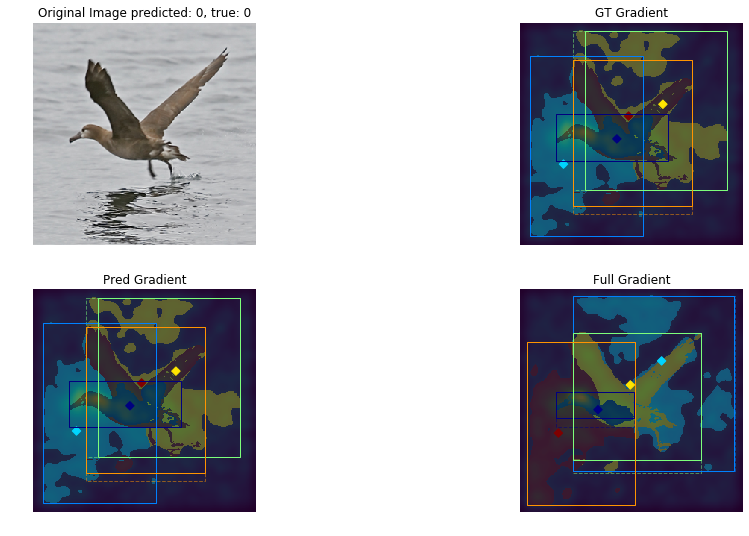

GT class: 0, pred class: 0


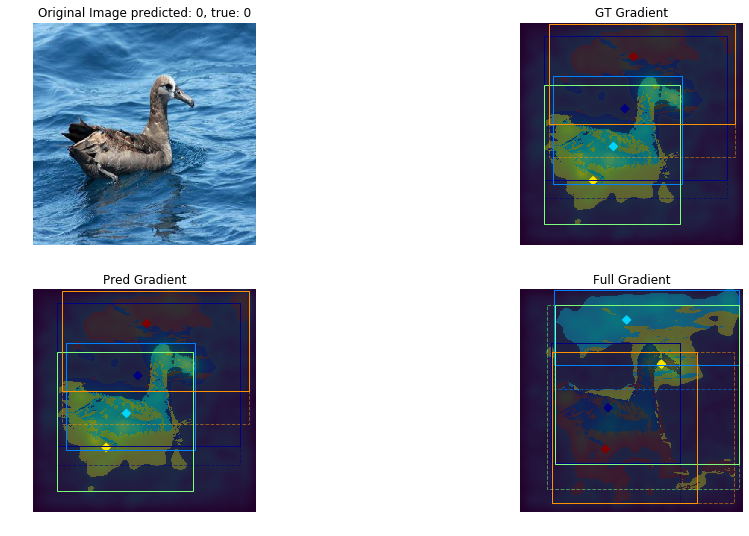

GT class: 0, pred class: 0


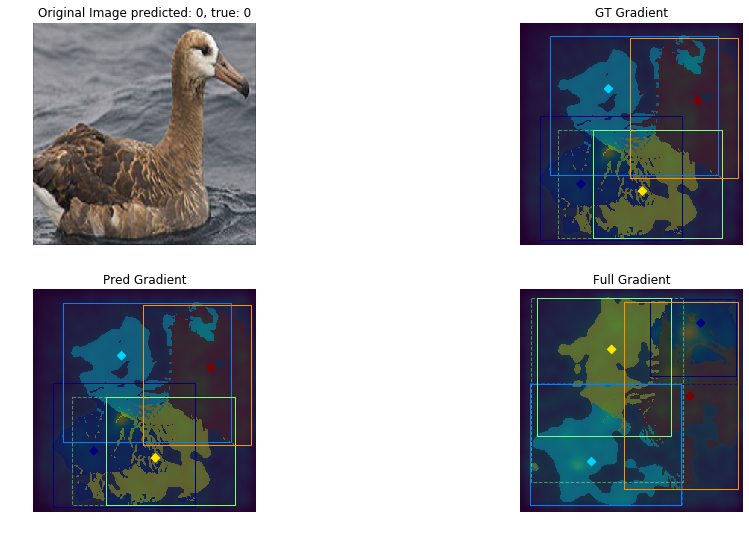

GT class: 0, pred class: 0


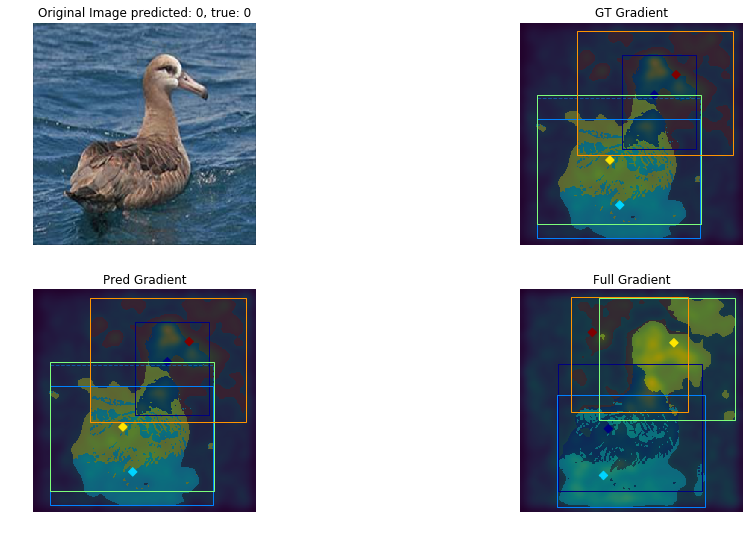

In [16]:
it.reset()
bar = ProgressBar()
n_batches = int(np.ceil(len(it.dataset) / it.batch_size))


res = []
for i, batch in bar(enumerate(it), every=5, size=n_batches):
    batch = prepare_batch(batch, cnn.prepare)
    
    X, parts, y = concat_examples(batch, device=GPU)
    n, c, h, w = X.shape
    
    ims = chainer.Variable(X)
    with chainer.using_config("train", False):#, chainer.no_backprop_mode():
        feats = cnn(ims, layer_name=cnn.meta.feature_layer)
        if isinstance(feats, tuple):
            feats = feats[0]
        
    f = scaler.transform(to_cpu(feats.array))
    gt = to_cpu(y)

    decs = clf.decision_function(f)
    sorted_pred = np.argsort(decs)
    top5_preds = sorted_pred[:, -5:]
    top5_accu = (top5_preds == np.expand_dims(gt, 1)).max(axis=1).mean()
    
    #preds = clf.predict(f)
    
    print("Batch Accuracy: {:.4%} (Top1) | {:.4%} (Top5) {: 3d} / {: 3d}".format(
       
       np.mean(top5_preds[:, -1] == gt),
       top5_accu,
       
       np.sum(top5_preds[:, -1] == gt),
       len(batch)
    ))
    
    kwargs = dict(
      gamma=0.7, sigma=5, 
      K=4, init_from_maximas=True
    )
    
#     with open("pred_parts.txt", "w") as pred_out, open("full_parts.txt", "w") as full_out: 
#         for b, parts in enumerate(extract_parts(ims, y, feats, top5_preds, **kwargs)):
#             for pred_part, full_part in zip(*parts):
#                 parts_to_file(i * it.batch_size + b, *pred_part, out=pred_out)
#                 parts_to_file(i * it.batch_size + b, *full_part, out=full_out)
#                 #print(i * it.batch_size + b+1, p+1)#, (pred_part, full_part))
#                 pass
        
    show_feature_saliency(ims, y, feats, top5_preds, 
                         peak_size=None, #int(h * 0.35 / 2),
                         **kwargs,
                        )
    
    #with chainer.using_config("train", False), chainer.no_backprop_mode():
    #    conv_maps = cnn(ims, layer_name=cnn.meta.conv_map_layer)
    #    if isinstance(conv_maps, tuple):
    #        conv_maps = conv_maps[0]
    #show_conv_maps(to_cpu(X), to_cpu(y), to_cpu(conv_maps.array), top5_preds, order=3)
    
    #res.extend(top5_preds[:, -1] == gt)
    
    break

# Extract new parts for all data

In [18]:
if False:
    raise ValueError("Don't call this cell!")

data = Dataset(uuids=annot.uuids, annotations=annot)
print("Found {} images".format(len(data)))

_it = MultiprocessIterator(
    data, batch_size=BATCH_SIZE, repeat=False, shuffle=False,
    n_processes=2, n_prefetch=1, shared_mem=800000
)
_it.reset()
bar = ProgressBar()
n_batches = int(np.ceil(len(_it.dataset) / _it.batch_size))

with open("pred_parts.txt", "w") as pred_out, open("full_parts.txt", "w") as full_out:
    
    for i, batch in bar(enumerate(_it), every=1, size=n_batches):
        batch = prepare_batch(batch, cnn.prepare)

        X, parts, y = concat_examples(batch, device=GPU)
        n, c, h, w = X.shape

        ims = chainer.Variable(X)
        with chainer.using_config("train", False):#, chainer.no_backprop_mode():
            feats = cnn(ims, layer_name=cnn.meta.feature_layer)
            if isinstance(feats, tuple):
                feats = feats[0]

        f = scaler.transform(to_cpu(feats.array))
        gt = to_cpu(y)

        decs = clf.decision_function(f)
        sorted_pred = np.argsort(decs)
        top5_preds = sorted_pred[:, -5:]
        top5_accu = (top5_preds == np.expand_dims(gt, 1)).max(axis=1).mean()

        kwargs = dict(
          gamma=0.7, sigma=5, 
          K=4, init_from_maximas=True
        )
     
        for b, parts in enumerate(extract_parts(ims, y, feats, top5_preds, **kwargs)):
            for pred_part, full_part in zip(*parts):
                parts_to_file(i * _it.batch_size + b, *pred_part, out=pred_out)
                parts_to_file(i * _it.batch_size + b, *full_part, out=full_out)
    #break

Found 11788 images
